## Intersect points with a regular grid without a spatial index
- Source: https://github.com/carlosg-m/goose-lab

In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely 

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#### Intersect points with a regular grid using Numpy
- Intersecing points with a regular grid on a cartesian plane can be done efficiently using only NumPy and vectorized operations, without relying on spatial indexes or brute force approaches.

In [2]:
def create_grid(xmin, ymin, xmax, ymax, xstep, ystep):
    """
    Create bounding coordinates for a regular 2d grid with numpy.
    These coordinates can then be used with shapely, pygeos and geopandas.
    """
    
    # Generate two evenly spaced ranges
    x = np.linspace(xmin, xmax, int(xstep+1))
    y = np.linspace(ymin, ymax, int(ystep+1))
    
    # Get center points for each range
    x = np.mean((x[1:], x[:-1]), axis=0)
    y = np.mean((y[1:], y[:-1]), axis=0)
    
    # Cartesian product of both ranges 
    x, y = np.meshgrid(x, y)
    x, y = x.ravel(), y.ravel()

    # Calculate delta x and delta y
    xd = (xmax - xmin) / (xstep * 2)
    yd = (ymax - ymin) / (ystep * 2)
    
    # Repeat center points and add respective delta
    grid = np.column_stack((x,y))
    grid = np.tile(grid, 2) + np.array([[-xd, -yd, xd, yd]])
    
    # Generate index
    grid_index = np.arange(0, xstep * ystep)
    
    # Output coordinates: xmin, ymin, xmax, ymax
    return grid, grid_index

def intersect_points_grid(xy, xmin, ymin, xmax, ymax, xstep, ystep, include_xmax=False, include_ymax=False):
    """
    Intersect 2d Points with a regular 2d Grid using NumPy.
    Returns the index of the Grid rectangle that each Point belongs to.
    """
    
    # Calculate delta x and delta y
    xd = (xmax - xmin) / xstep
    yd = (ymax - ymin) / ystep
    
    # Center points at zero
    xy = xy - np.array([[xmin, ymin]])
    
    # Get index of x and y coordinates
    xi = np.floor(xy[:,0] / xd) 
    yi = np.floor(xy[:,1] / yd)
    
    # Cast x and y index to 64 bit integer
    xi = xi.astype(np.int64)
    yi = yi.astype(np.int64)
    
    # Opened interval for x
    if include_xmax == True:
        xi = xi - (xy[:,0] % xd == 0)
    
    # Opened interval for y
    if include_ymax == True:
        yi = yi - (xy[:,1] % yd == 0)
        
    # Mask out-of-bound indexes on the x and y axis
    xi = np.ma.array(xi, mask=((xi < 0) | (xi >= xstep)))
    yi = np.ma.array(yi, mask=((yi < 0) | (yi >= ystep)))
        
    # Calculate index
    index = xi + (yi * xstep)
    
    # Unmask NumPy array
    index = index.filled(np.iinfo(np.int64).min)
    
    return index


##### Create example grid

In [3]:
grid, grid_index = create_grid(xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5)

##### Create example points

In [4]:
test_points = np.array([[10, 50],
                        [10, 60],
                        [20, 50],
                        [20, 60],
                        [11, 51],
                        [14, 54],
                        [11.5, 57.7],
                        [17.5, 54.5]])

##### Plot grid and Points

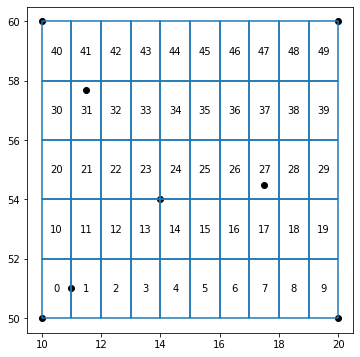

In [5]:
grid_shapely = list(map(lambda x: shapely.geometry.box(*x), grid))

fig, ax = plt.subplots(figsize=(6,6))

gpd.GeoDataFrame(geometry=grid_shapely).exterior.plot(ax=ax)

for coos, index in zip(grid, grid_index):
    ax.text(coos[[0,2]].mean(), coos[[1,3]].mean(), str(index), horizontalalignment='center', verticalalignment='center')
    
ax.scatter(test_points[:,0], test_points[:,1], color='black')

##### Intersect Points with Grid
- The parameters that define the grid must be known.
- Points that are out of bounds have as index the smallest possible value that can be represented by a 64 bit integer.

In [6]:
intersect_points_grid(xy=test_points, 
                      xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5, 
                      include_xmax=False, include_ymax=False)

array([                   0, -9223372036854775808, -9223372036854775808,
       -9223372036854775808,                    1,                   24,
                         31,                   27])

##### Next steps
- Now it's possible to use NumPy indexing or a database join (Pandas, Dask or Pyspark), to merge 2d Points with their respective rectangle on a predefined regular grid.

In [7]:
index = intersect_points_grid(xy=test_points, 
                              xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5, 
                              include_xmax=False, include_ymax=False)

In [8]:
test_points[index>=0]

array([[10. , 50. ],
       [11. , 51. ],
       [14. , 54. ],
       [11.5, 57.7],
       [17.5, 54.5]])

In [9]:
grid[index[index>=0]]

array([[10., 50., 11., 52.],
       [11., 50., 12., 52.],
       [14., 54., 15., 56.],
       [11., 56., 12., 58.],
       [17., 54., 18., 56.]])

##### Another example - single square

In [10]:
grid, grid_index = create_grid(xmin=0, ymin=0, xmax=1, ymax=1, xstep=1, ystep=1)

In [11]:
test_points = np.array([[0,0],
                        [0,1],
                        [1,0],
                        [1,1]])

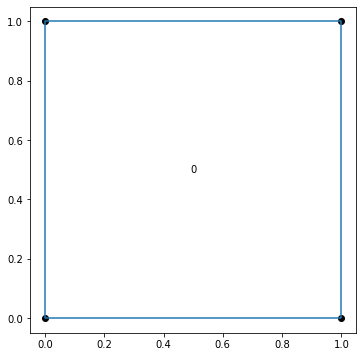

In [12]:
grid_shapely = list(map(lambda x: shapely.geometry.box(*x), grid))

fig, ax = plt.subplots(figsize=(6,6))

gpd.GeoDataFrame(geometry=grid_shapely).exterior.plot(ax=ax)

for coos, index in zip(grid, grid_index):
    ax.text(coos[[0,2]].mean(), coos[[1,3]].mean(), str(index), horizontalalignment='center', verticalalignment='center')
    
ax.scatter(test_points[:,0], test_points[:,1], color='black')

##### Intersect Points with Grid
- The boolean parameters include_xmax and include_ymax determine which bounds are inclusive and exclusive. 
- If both are false the bottom left corner of the grid (origin) will be considered inclusive, and the other 3 corners exclusive.
- For the other points that lie inside the rectangles the index will remain the same.

In [13]:
intersect_points_grid(xy=test_points, 
                      xmin=0, ymin=0, xmax=1, ymax=1, xstep=1, ystep=1, 
                      include_xmax=False, include_ymax=False)

array([                   0, -9223372036854775808, -9223372036854775808,
       -9223372036854775808])

In [14]:
intersect_points_grid(xy=test_points, 
                      xmin=0, ymin=0, xmax=1, ymax=1, xstep=1, ystep=1, 
                      include_xmax=False, include_ymax=True)

array([-9223372036854775808,                    0, -9223372036854775808,
       -9223372036854775808])

In [15]:
intersect_points_grid(xy=test_points, 
                      xmin=0, ymin=0, xmax=1, ymax=1, xstep=1, ystep=1, 
                      include_xmax=True, include_ymax=False)

array([-9223372036854775808, -9223372036854775808,                    0,
       -9223372036854775808])

In [16]:
intersect_points_grid(xy=test_points, 
                      xmin=0, ymin=0, xmax=1, ymax=1, xstep=1, ystep=1, 
                      include_xmax=True, include_ymax=True)

array([-9223372036854775808, -9223372036854775808, -9223372036854775808,
                          0])